In [33]:
import numpy as np
import pandas as pd 
from clickhouse_driver import Client
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
def callClickhouse(sql):
    client = Client(host='clickhouse.db.trell.co', database='analytics',user='default', password='expresso123$')
    query_result = client.execute(sql)
    df = pd.DataFrame(query_result)
    return df

In [3]:
! pip install clickhouse-driver

In [4]:
sql1 = """select A.userId,B.userName,B.handleName,B.followers_count,
count(distinct A.trailId) as vlogcounts,
count(distinct toDate(A.createdAt)) as uniquedateCreation
from trellDbDump.userTrails A
left join trellDbDump.users B 
on A.userId = B.userId
where B.mode != 'manual' and A.isDeleted = 0 and B.userName not like '%treller%'
group by A.userId,B.userName,B.handleName,B.followers_count
order by B.followers_count desc"""

In [5]:
data = callClickhouse(sql1)

In [6]:
data.rename(columns={0:'userId',1:'userName',2:'handleName',3:'Followers',4:'vlogCounts',5:'UDC'},inplace=True)

In [7]:
np.corrcoef(data['vlogCounts'],data['UDC'])[0][1]

0.6917595804148702

In [8]:
data.shape

(308735, 6)

In [9]:
sample = data.sample(n=30)

In [10]:
coef_ = []
for i in range(1,30):
    sample = data.sample(n=10000)
    np.corrcoef(sample['vlogCounts'],sample['UDC'])[0][1]
    coef_.append(np.corrcoef(sample['vlogCounts'],sample['UDC'])[0][1])

In [11]:
np.mean(coef_)

0.7152751003616015

(array([3., 4., 1., 1., 1., 5., 3., 6., 3., 2.]),
 array([0.5135211 , 0.55087641, 0.58823173, 0.62558704, 0.66294236,
        0.70029768, 0.73765299, 0.77500831, 0.81236363, 0.84971894,
        0.88707426]),
 <a list of 10 Patch objects>)

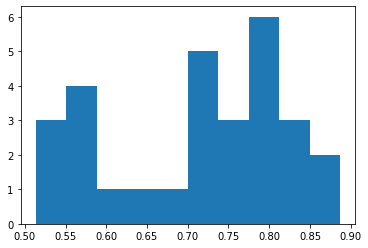

In [12]:
plt.hist(coef_)

In [13]:
np.sum([x for x in coef_ if x <= 0.69])/len(coef_)

0.17523510566652975

In [14]:
np.corrcoef(data['vlogCounts'],data['Followers'])[0][1]

0.44785137537558156

In [15]:
sample = data.sample(n=29)

In [16]:
coef_1 = []
for i in range(1,30):
    sample = data.sample(n=10000)
    np.corrcoef(sample['vlogCounts'],sample['Followers'])[0][1]
    coef_1.append(np.corrcoef(sample['vlogCounts'],sample['Followers'])[0][1])

In [17]:
np.mean(coef_1)

0.48736013794992783

(array([4., 2., 0., 7., 7., 4., 2., 2., 0., 1.]),
 array([0.31623518, 0.35694835, 0.39766153, 0.4383747 , 0.47908787,
        0.51980104, 0.56051421, 0.60122738, 0.64194055, 0.68265372,
        0.7233669 ]),
 <a list of 10 Patch objects>)

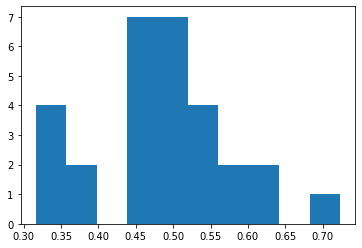

In [18]:
plt.hist(coef_1)

In [19]:
stats.expon.pdf(coef_1)

array([0.62525159, 0.68905721, 0.62226306, 0.5352335 , 0.57514149,
       0.72779552, 0.59049524, 0.57793319, 0.68716667, 0.61126797,
       0.603076  , 0.70825547, 0.53821909, 0.70674577, 0.62620953,
       0.5951323 , 0.61406537, 0.48511617, 0.55529164, 0.62224469,
       0.72888801, 0.5974501 , 0.56396682, 0.60192678, 0.62913885,
       0.59362602, 0.60516446, 0.64382067, 0.63038583])

In [20]:
data.head(5)

,userId,userName,handleName,Followers,vlogCounts,UDC
0,345343,Subha Chugh,SaveyRaah,68979,214,114
1,1,Trell,Trell,47796,77,135
2,859235,Bhushan Patil,BhushanPatil,44122,269,54
3,42424,Atreya Mathur,AtreyaMathur,44053,249,135
4,219058,Namrata Sarma,neetatouille,33129,198,160


In [21]:
data.isna().sum()

userId        0
userName      0
handleName    0
Followers     0
vlogCounts    0
UDC           0
dtype: int64

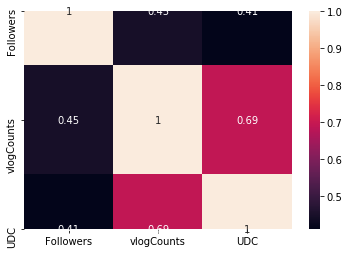

In [22]:
sns.heatmap(data[['Followers','vlogCounts','UDC']].corr(),annot=True,)

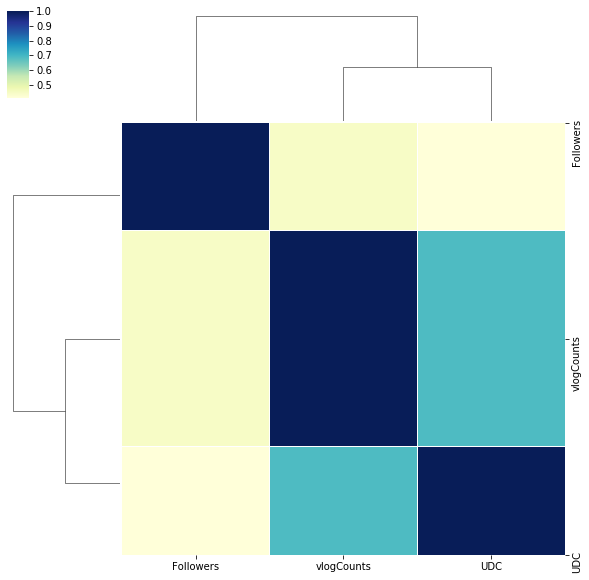

In [23]:
#2: Grid Correlation Matrix

corrmat = data[['Followers','vlogCounts','UDC']].corr() 
  
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
cg 

In [24]:

sql2 = """select B.userId as userId,count(A.userId) as likes
from trellDbDump.trailLove A
left join trellDbDump.userTrails B
on A.trailId =B.trailId
where A.counter > 0
group by userId
"""

In [25]:
data1 = callClickhouse(sql2)

In [26]:
data1.rename(columns={0:'userId',1:'Total_Likes'},inplace=True)

In [27]:
data3 = pd.merge(data,data1,how='left',on='userId')

In [28]:
data3.head(5)

,userId,userName,handleName,Followers,vlogCounts,UDC,Total_Likes
0,345343,Subha Chugh,SaveyRaah,68979,214,114,13585597.0
1,1,Trell,Trell,47796,77,135,1077339.0
2,859235,Bhushan Patil,BhushanPatil,44122,269,54,8100893.0
3,42424,Atreya Mathur,AtreyaMathur,44053,249,135,4113226.0
4,219058,Namrata Sarma,neetatouille,33129,198,160,18763057.0


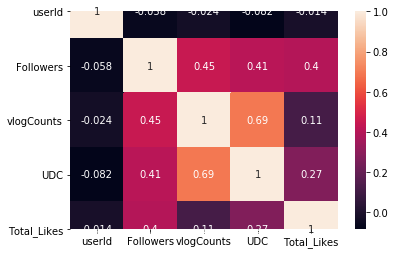

In [29]:
sns.heatmap(data3.corr(),annot=True)

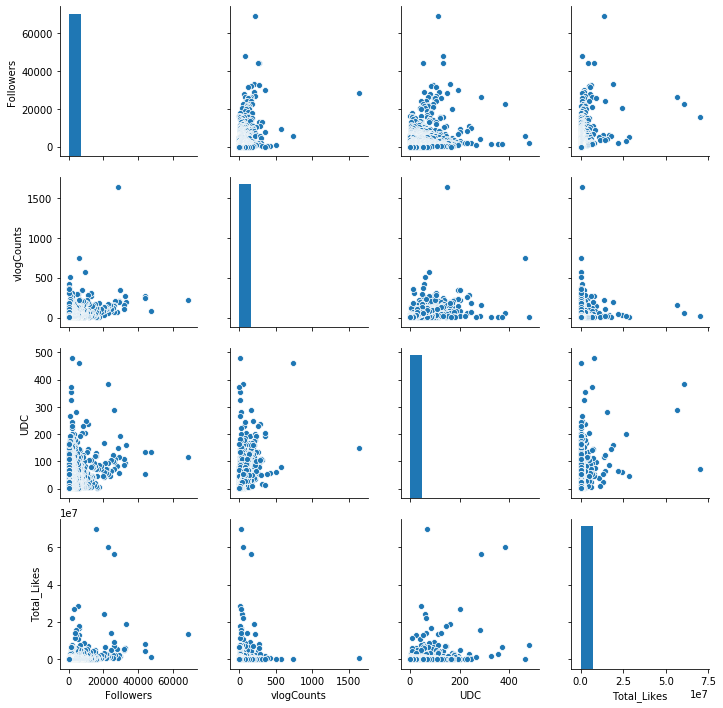

In [34]:
sns.pairplot(data3[['Followers','vlogCounts','UDC','Total_Likes']])

## clustering 

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing  import StandardScaler
from sklearn import preprocessing

In [36]:
data3.head()

,userId,userName,handleName,Followers,vlogCounts,UDC,Total_Likes
0,345343,Subha Chugh,SaveyRaah,68979,214,114,13585597.0
1,1,Trell,Trell,47796,77,135,1077339.0
2,859235,Bhushan Patil,BhushanPatil,44122,269,54,8100893.0
3,42424,Atreya Mathur,AtreyaMathur,44053,249,135,4113226.0
4,219058,Namrata Sarma,neetatouille,33129,198,160,18763057.0


In [48]:
scaler = StandardScaler()
data_2=scaler.fit_transform(data3[["Followers",'vlogCounts',"UDC","Total_Likes"]])

In [39]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308735 entries, 0 to 308734
Data columns (total 7 columns):
userId         308735 non-null int64
userName       308735 non-null object
handleName     308735 non-null object
Followers      308735 non-null int64
vlogCounts     308735 non-null int64
UDC            308735 non-null int64
Total_Likes    299083 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 28.8+ MB


In [40]:
data3.describe()

,userId,Followers,vlogCounts,UDC,Total_Likes
count,3.087350e+05,308735.000000,308735.000000,308735.000000,2.990830e+05
mean,1.325640e+06,43.725188,2.654714,2.338313,4.898907e+03
std,1.189421e+06,405.338578,7.169756,5.791759,2.503936e+05
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000e+00
25%,3.850510e+05,4.000000,1.000000,1.000000,5.000000e+00
50%,1.130630e+06,13.000000,1.000000,1.000000,3.200000e+01
75%,1.957962e+06,30.000000,2.000000,2.000000,2.380000e+02
max,6.935089e+06,68979.000000,1638.000000,480.000000,7.010401e+07


In [41]:
data3.isna().sum()

userId            0
userName          0
handleName        0
Followers         0
vlogCounts        0
UDC               0
Total_Likes    9652
dtype: int64

In [42]:
data3.shape

(308735, 7)

In [43]:
data3['Total_Likes'] = data3['Total_Likes'].fillna((data3['Total_Likes'].median()))
    

In [44]:
data3.isna().sum()

userId         0
userName       0
handleName     0
Followers      0
vlogCounts     0
UDC            0
Total_Likes    0
dtype: int64

In [49]:
normalized_X = preprocessing.normalize(data_2)

In [50]:
Kmean = KMeans(n_clusters=4)
kmeans_model=Kmean.fit(data_2)

In [51]:
Kmean.cluster_centers_

array([[-3.58014528e-02, -6.48879368e-02, -7.68503703e-02,
        -1.39298621e-02],
       [ 1.90849751e+00,  5.11976915e+00,  6.19808551e+00,
         4.55874261e-01],
       [ 5.30255712e+01,  1.05087832e+01,  4.22431406e+01,
         2.53034862e+02],
       [ 3.92397075e+01,  1.84920661e+01,  1.65908866e+01,
         1.81349429e+01]])

In [52]:
Kmean.labels_

array([3, 3, 3, ..., 0, 0, 0])

In [53]:
data3.head(5)

,userId,userName,handleName,Followers,vlogCounts,UDC,Total_Likes
0,345343,Subha Chugh,SaveyRaah,68979,214,114,13585597.0
1,1,Trell,Trell,47796,77,135,1077339.0
2,859235,Bhushan Patil,BhushanPatil,44122,269,54,8100893.0
3,42424,Atreya Mathur,AtreyaMathur,44053,249,135,4113226.0
4,219058,Namrata Sarma,neetatouille,33129,198,160,18763057.0


In [54]:
centers = np.array(kmeans_model.cluster_centers_)

In [ ]:
plt.plot()
plt.title('k means centroids')

for i, l in enumerate(kmeans_model.labels_):
    plt.plot(data_2,ls='None')
    plt.xlim([0, 10])
    plt.ylim([0, 10])

plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.show()


MemoryError: 